### What is CVXPY?
CVXPY is a Python-embedded modeling language for convex optimization problems. It automatically transforms the problem into standard form, calls a solver, and unpacks the results.

#### simple optimization problem in CVXPY

In [15]:
import cvxpy as cp

# Create two scalar optimization variables.
x = cp.Variable()
y = cp.Variable()

# Create two constraints.
constraints = [x + y == 1,
               x - y >= 1]

# Form objective.
obj = cp.Minimize((x - y)**2)

# Form and solve problem.
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value, y.value)

status: optimal
optimal value 1.0
optimal var 1.0 1.570086213240983e-22


The status, which was assigned a value “optimal” by the solve method, tells us the problem was solved successfully. The optimal value (basically 1 here) is the minimum value of the objective over all choices of variables that satisfy the constraints. The last thing printed gives values of x and y (basically 1 and 0 respectively) that achieve the optimal objective.

prob.solve() returns the optimal value and updates prob.status, prob.value, and the value field of all the variables in the problem.

#### Changing the problem
Problems are immutable, meaning they cannot be changed after they are created. To change the objective or constraints, create a new problem.

In [16]:
# Replace the objective.
prob2 = cp.Problem(cp.Maximize(x + y), prob.constraints)
print("optimal value", prob2.solve())

# Replace the constraint (x + y == 1).
constraints = [x + y <= 3] + prob2.constraints[1:]
prob3 = cp.Problem(prob2.objective, constraints)
print("optimal value", prob3.solve())

optimal value 0.9999999999999999
optimal value 2.999999999410368


#### Infeasible and unbounded problems
If a problem is infeasible or unbounded, the status field will be set to “infeasible” or “unbounded”, respectively. The value fields of the problem variables are not updated.

Notice that for a minimization problem the optimal value is inf if infeasible and -inf if unbounded. For maximization problems the opposite is true.

#### Other problem statuses
If the solver called by CVXPY solves the problem but to a lower accuracy than desired, the problem status indicates the lower accuracy achieved. The statuses indicating lower accuracy are

- “optimal_inaccurate”
- “unbounded_inaccurate”
- “infeasible_inaccurate”

The problem variables are updated as usual for the type of solution found (i.e., optimal, unbounded, or infeasible).

If the solver completely fails to solve the problem, CVXPY throws a SolverError exception. If this happens you should try using other solvers. See the discussion of Solvers for details.

CVXPY provides the following constants as aliases for the different status strings:

- OPTIMAL
- INFEASIBLE
- UNBOUNDED
- OPTIMAL_INACCURATE
- INFEASIBLE_INACCURATE
- UNBOUNDED_INACCURATE
- INFEASIBLE_OR_UNBOUNDED

To test if a problem was solved successfully, you would use

```python 
prob.status == OPTIMAL
```
The status INFEASIBLE_OR_UNBOUNDED is rare. It’s used when a solver was able to determine that the problem was either infeasible or unbounded, but could not tell which. You can determine the precise status by re-solving the problem where you set the objective function to a constant (e.g., objective = cp.Minimize(0)). If the new problem is solved with status code INFEASIBLE_OR_UNBOUNDED then the original problem was infeasible. If the new problem is solved with status OPTIMAL then the original problem was unbounded.

In [17]:
import cvxpy as cp

x = cp.Variable()

# An infeasible problem.
prob = cp.Problem(cp.Minimize(x), [x >= 1, x <= 0])
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

# An unbounded problem.
prob = cp.Problem(cp.Minimize(x))
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

status: infeasible
optimal value inf
status: unbounded
optimal value -inf


#### Vectors and matrices
Variables can be scalars, vectors, or matrices, meaning they are 0, 1, or 2 dimensional.

In [18]:
# A scalar variable.
a = cp.Variable()

# Vector variable with shape (5,).
x = cp.Variable(5)

# Matrix variable with shape (5, 1).
x = cp.Variable((5, 1))

# Matrix variable with shape (4, 7).
A = cp.Variable((4, 7))

You can use your numeric library of choice to construct matrix and vector constants. For instance, if x is a CVXPY Variable in the expression A @ x + b, A and b could be Numpy ndarrays, SciPy sparse matrices, etc. A and b could even be different types.

Currently the following types may be used as constants:

- NumPy ndarrays
- NumPy matrices
- SciPy sparse matrices

Here’s an example of a CVXPY problem with vectors and matrices:

In [19]:
# Solves a bounded least-squares problem.

import cvxpy as cp
import numpy

# Problem data.
m = 10
n = 5
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.

Optimal value 4.141338603672535
Optimal var
[-4.95922264e-21  6.07571976e-21  1.34643668e-01  1.24976681e-01
 -4.57130806e-21]


#### Constraints
As shown in the example code, you can use ==, <=, and >= to construct constraints in CVXPY. Equality and inequality constraints are elementwise, whether they involve scalars, vectors, or matrices. For example, together the constraints 0 <= x and x <= 1 mean that every entry of x is between 0 and 1.

If you want matrix inequalities that represent semi-definite cone constraints, see Semidefinite matrices. The section explains how to express a semi-definite cone inequality.

You cannot construct inequalities with < and >. Strict inequalities don’t make sense in a real world setting. Also, you cannot chain constraints together, e.g., 0 <= x <= 1 or x == y == 2. The Python interpreter treats chained constraints in such a way that CVXPY cannot capture them. CVXPY will raise an exception if you write a chained constraint.

In [20]:
# Solves a bounded least-squares problem.

import cvxpy as cp
import numpy

# Problem data.
m = 10
n = 5
numpy.random.seed(1)
A = numpy.random.randn(m, n)
b = numpy.random.randn(m)

# Construct the problem.
x = cp.Variable(n)
objective = cp.Minimize(cp.sum_squares(A @ x - b))
constraints = [0 <= x, x <= 1]
prob = cp.Problem(objective, constraints)

print("Optimal value", prob.solve())
print("Optimal var")
print(x.value) # A numpy ndarray.

Optimal value 4.141338603672535
Optimal var
[-4.95922264e-21  6.07571976e-21  1.34643668e-01  1.24976681e-01
 -4.57130806e-21]


#### Parameters
Parameters are symbolic representations of constants. The purpose of parameters is to change the value of a constant in a problem without reconstructing the entire problem. In many cases, solving a parametrized program multiple times can be substantially faster than repeatedly solving a new problem: after reading this section, be sure to read the tutorial on Disciplined Parametrized Programming (DPP).

Parameters can be vectors or matrices, just like variables. When you create a parameter you have the option of specifying attributes such as the sign of the parameter’s entries, whether the parameter is symmetric, etc. These attributes are used in Disciplined Convex Programming and are unknown unless specified. Parameters can be assigned a constant value any time after they are created. The constant value must have the same dimensions and attributes as those specified when the parameter was created.

You can initialize a parameter with a value. The following code segments are equivalent:

In [21]:
# Positive scalar parameter.
m = cp.Parameter(nonneg=True)

# Column vector parameter with unknown sign (by default).
c = cp.Parameter(5)

# Matrix parameter with negative entries.
G = cp.Parameter((4, 7), nonpos=True)

# Assigns a constant value to G.
G.value = -numpy.ones((4, 7))

You can initialize a parameter with a value. The following code segments are equivalent:

In [22]:
# Create parameter, then assign value.
rho = cp.Parameter(nonneg=True)
rho.value = 2

# Initialize parameter with a value.
rho = cp.Parameter(nonneg=True, value=2)

Computing trade-off curves is a common use of parameters. The example below computes a trade-off curve for a LASSO problem.

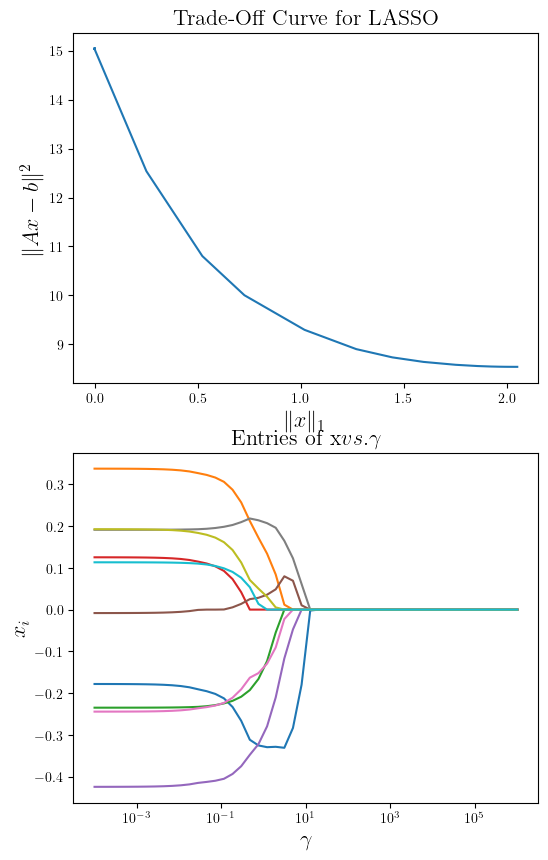

In [23]:
import cvxpy as cp
import numpy
import matplotlib.pyplot as plt

# Problem data.
n = 15
m = 10
numpy.random.seed(1)
A = numpy.random.randn(n, m)
b = numpy.random.randn(n)
# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

# Construct the problem.
x = cp.Variable(m)
error = cp.sum_squares(A @ x - b)
obj = cp.Minimize(error + gamma*cp.norm(x, 1))
prob = cp.Problem(obj)

# Construct a trade-off curve of ||Ax-b||^2 vs. ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []
gamma_vals = numpy.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    # Use expr.value to get the numerical value of
    # an expression in the problem.
    sq_penalty.append(error.value)
    l1_penalty.append(cp.norm(x, 1).value)
    x_values.append(x.value)

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
#mpl.rcParams['text.latex.preamble'] = [r'\\usepackage{amsmath}'] 
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(6,10))

# Plot trade-off curve.
plt.subplot(211)
plt.plot(l1_penalty, sq_penalty)
plt.xlabel(r"$\|x\|_1$", fontsize=16)
plt.ylabel(r'$\|Ax-b\|^2$', fontsize=16)
plt.title('Trade-Off Curve for LASSO', fontsize=16)

# Plot entries of x vs. gamma.
plt.subplot(212)
for i in range(m):
    plt.plot(gamma_vals, [xi[i] for xi in x_values])
plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel(r'$x_{i}$', fontsize=16)
plt.xscale('log')
plt.title(r'$ \text{Entries of x} vs.  \gamma $', fontsize=16)

plt.show()

Trade-off curves can easily be computed in parallel. The code below computes in parallel the optimal x for each in the LASSO problem above.

In [24]:
from multiprocessing import Pool

# Assign a value to gamma and find the optimal x.
def get_x(gamma_value):
    gamma.value = gamma_value
    result = prob.solve()
    return x.value

# Parallel computation (set to 1 process here).
pool = Pool(processes = 10)
x_values = pool.map(get_x, gamma_vals)

In [25]:
x_values

[array([-0.17823789,  0.33773964, -0.23499467,  0.12534639, -0.42465828,
        -0.00829153, -0.24445595,  0.19126012,  0.19263571,  0.11334233]),
 array([-0.17826499,  0.33771688, -0.2349905 ,  0.12532425, -0.42463802,
        -0.00827532, -0.24443872,  0.19126302,  0.19261657,  0.11333574]),
 array([-0.17830845,  0.33768015, -0.23498372,  0.1252888 , -0.42460567,
        -0.00824934, -0.24441117,  0.19126762,  0.19258593,  0.11332508]),
 array([-0.17837786,  0.33762142, -0.23497283,  0.12523215, -0.42455395,
        -0.0082078 , -0.24436713,  0.19127494,  0.19253697,  0.11330802]),
 array([-0.17848912,  0.3375273 , -0.23495535,  0.12514138, -0.4244711 ,
        -0.00814131, -0.24429653,  0.19128669,  0.19245853,  0.11328078]),
 array([-0.17866698,  0.33737702, -0.23492767,  0.12499628, -0.42433873,
        -0.00803497, -0.24418383,  0.19130549,  0.19233312,  0.11323709]),
 array([-0.17895163,  0.33713616, -0.23488305,  0.12476425, -0.42412616,
        -0.00786396, -0.24400316,  0.19

In [26]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Mon Oct 07 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

matplotlib: 3.9.0
cvxpy     : 1.5.1
numpy     : 1.26.4

Watermark: 2.4.3

